In [393]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn.linear_model as lm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import LeaveOneOut, GroupKFold, StratifiedGroupKFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

### Reading DF

In [394]:
HR_data_template = pd.read_csv('HR_data.csv')
HR_data = HR_data_template.drop('Unnamed: 0', axis=1)

label_encoder = LabelEncoder()
HR_data['Phase'] = label_encoder.fit_transform(HR_data['Phase'])
HR_data['Round'] = label_encoder.fit_transform(HR_data['Round'])
HR_data['Cohort'] = label_encoder.fit_transform(HR_data['Cohort'])
HR_data['Puzzler'] = label_encoder.fit_transform(HR_data['Puzzler'])

HR_data.head(2)


,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,77.965186,78.00,3.345290,73.23,83.37,22924.945,2,2,1,1,1,0
1,70.981097,70.57,2.517879,67.12,78.22,21930.400,2,1,1,1,5,0


### Correlation matrix

<AxesSubplot: >

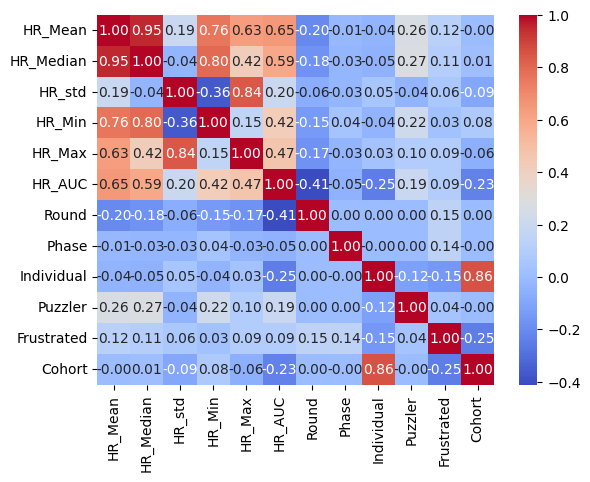

In [395]:
corr = HR_data.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')

### Data distributions

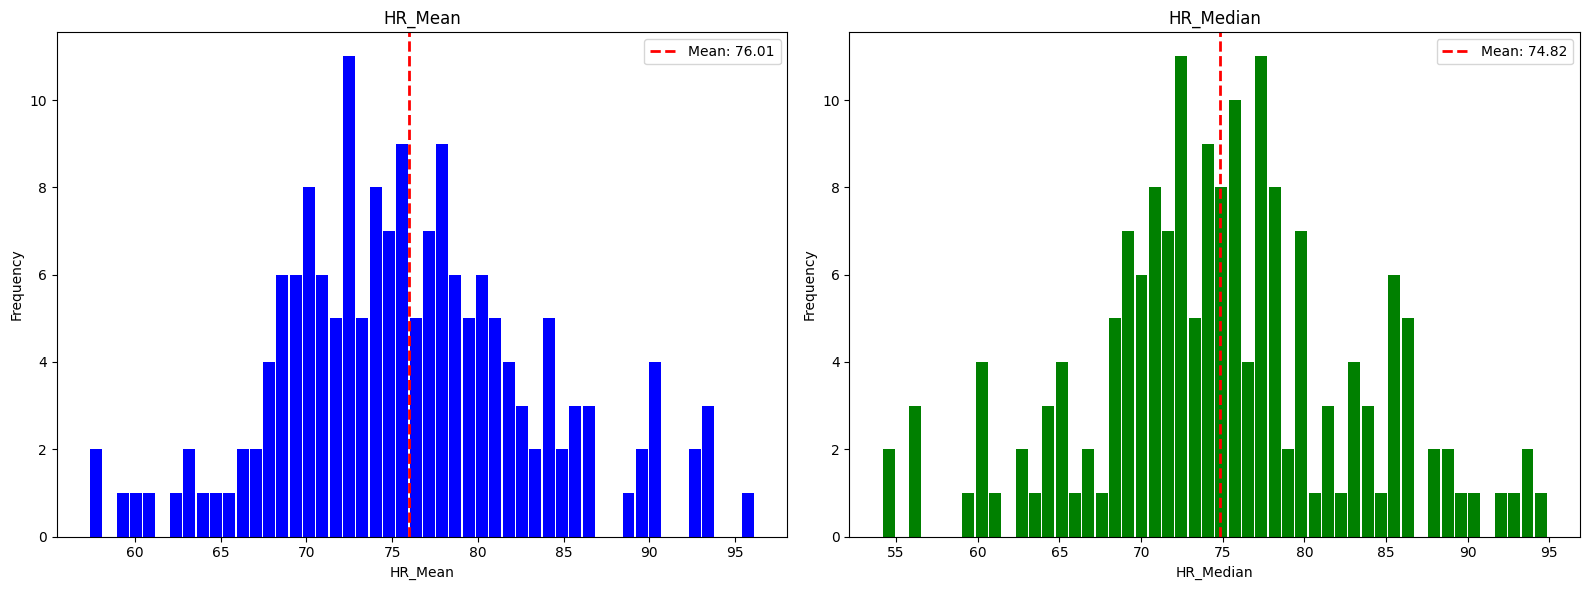

In [396]:
mean_value_mean = HR_data['HR_Mean'].mean()
mean_value_median = HR_data['HR_Median'].mean()

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Histogram for HR_Mean
ax[0].hist(HR_data['HR_Mean'], bins=50, color='b', rwidth=0.9)
ax[0].axvline(mean_value_mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {round(mean_value_mean, 2)}')
ax[0].set_title('HR_Mean')
ax[0].set_xlabel('HR_Mean')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Histogram for HR_Median
ax[1].hist(HR_data['HR_Median'], bins=50, color='g', rwidth=0.9)
ax[1].axvline(mean_value_median, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {round(mean_value_median, 2)}')
ax[1].set_title('HR_Median')
ax[1].set_xlabel('HR_Median')
ax[1].set_ylabel('Frequency')
ax[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Encode the target variable into 3

In [397]:
def encode_frustration(score):
    if score <= 3:
        return 0
    elif 4 <= score <= 6:
        return 1
    else:
        return 2
    
HR_data['Frustration_Level'] = HR_data['Frustrated'].apply(encode_frustration)
HR_data.head()

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort,Frustration_Level
0,77.965186,78.00,3.345290,73.23,83.37,22924.945,2,2,1,1,1,0,0
1,70.981097,70.57,2.517879,67.12,78.22,21930.400,2,1,1,1,5,0,1
2,73.371959,73.36,3.259569,67.88,80.22,21647.085,2,0,1,1,0,0,0
3,78.916822,77.88,4.054595,72.32,84.92,25258.905,1,2,1,1,1,0,0
4,77.322226,74.55,6.047603,70.52,90.15,23890.565,1,1,1,1,5,0,1


### HR_max during the 3 phases

In [398]:
HR_data.loc[HR_data['Phase']==0]['HR_Max'].mean(),HR_data.loc[HR_data['Phase']==1]['HR_Max'].mean(),HR_data.loc[HR_data['Phase']==2]['HR_Max'].mean()

(88.24035714285716, 91.73446428571427, 87.21124999999999)

### Frustation level for different phase,round,puzzler 

#### Round

In [399]:
HR_data.loc[HR_data['Round']==0]['Frustrated'].mean(),HR_data.loc[HR_data['Round']==1]['Frustrated'].mean(),HR_data.loc[HR_data['Round']==2]['Frustrated'].mean(),HR_data.loc[HR_data['Round']==3]['Frustrated'].mean()

(1.7142857142857142, 2.619047619047619, 2.119047619047619, 2.7142857142857144)

### Chi-square

##### Puzzler

In [403]:
# Create a contingency table
contingency_table = pd.crosstab(HR_data['Frustrated'], HR_data['Puzzler'])

# Perform the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square statistic: {chi2}")
print(f"P-value: {p}")

Chi-Square statistic: 4.99713752954552
P-value: 0.7578820344597234


### Splitting and training models

In [405]:
sgkf = StratifiedGroupKFold(n_splits=5,random_state=None, shuffle=False)

groups = HR_data['Individual']
X = HR_data[['HR_Median', 'HR_std', 'HR_Min', 'Round', 'Phase', 'Puzzler']] # 'Round', 'Phase', 'Puzzler', 'Cohort'
y = HR_data['Frustration_Level']

scaler = StandardScaler()
to_scale = ['HR_Median', 'HR_std', 'HR_Min']

X.loc[:, to_scale] = scaler.fit_transform(X[to_scale])

In [406]:
HR_data.loc[HR_data['Frustration_Level']==2]

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort,Frustration_Level
43,68.865497,69.425,2.723403,63.27,73.12,20725.905,3,1,4,1,7,0,2
64,83.983399,83.535,2.028127,80.82,94.28,25611.370,1,1,6,0,7,0,2
103,83.741293,85.210,4.214470,72.88,87.48,24540.430,3,1,9,1,8,1,2
139,81.151092,75.870,10.568501,70.15,106.92,23705.220,3,1,12,1,8,1,2
163,73.594539,72.380,9.474556,57.43,93.53,21482.985,3,1,14,0,8,1,2


In [415]:
for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_groups, test_groups = groups[train_index], groups[test_index]
    
    print(f"Fold {i}:")
    print("Test Groups:", np.unique(test_groups))


Fold 0:
Test Groups: [ 7 12 13]
Fold 1:
Test Groups: [ 2  9 10]
Fold 2:
Test Groups: [ 3 11 14]
Fold 3:
Test Groups: [4 8]
Fold 4:
Test Groups: [1 5 6]


In [450]:
logistic_reg = lm.LogisticRegression(max_iter=1000,random_state=1)
forest_classifier = RandomForestClassifier(random_state=1)

# Prepare to collect evaluation metrics
metrics_model1 = {'accuracy': [],'recall': [],'conf_matrix':[], 'y_pred': [], 'y_true':[], 'specificity':[]}
metrics_model2 = {'accuracy': [],'recall': [], 'conf_matrix':[], 'y_pred': [], 'y_true':[], 'specificity':[]}


# Perform Stratified Group K-Fold cross-validation
for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train model 1
    logistic_reg.fit(X_train, y_train)
    y_pred1 = logistic_reg.predict(X_test)
    
    # Evaluate model 1
    
    metrics_model1['accuracy'].append(accuracy_score(y_test, y_pred1))
    metrics_model1['recall'].append(recall_score(y_test, y_pred1, average='macro', zero_division=0))
    metrics_model1['conf_matrix'].append(confusion_matrix(y_test, y_pred1))
    metrics_model1['y_pred'].append(y_pred1)
    metrics_model1['y_true'].append(y_test)
    
    

    # Train model 2
    forest_classifier.fit(X_train, y_train)
    y_pred2 = forest_classifier.predict(X_test)
    
    # Evaluate model 2
    metrics_model2['accuracy'].append(accuracy_score(y_test, y_pred2))
    metrics_model2['recall'].append(recall_score(y_test, y_pred2, average='macro', zero_division=0))
    metrics_model2['conf_matrix'].append(confusion_matrix(y_test, y_pred2))
    metrics_model2['y_pred'].append(y_pred2)
    metrics_model2['y_true'].append(y_test)
    

# Print the evaluation metrics for model1
print("Model 1 (Logistic):")
print("Average Accuracy:", np.mean(metrics_model1['accuracy']))
print("Average Recall:", np.mean(metrics_model1['recall']))



# Print the evaluation metrics for model2
print("Model 2 (RandomForestClassifier):")
print("Average Accuracy:", np.mean(metrics_model2['accuracy']))
print("Average Recall:", np.mean(metrics_model2['recall']))



Model 1 (Logistic):
Average Accuracy: 0.7138888888888889
Average Recall: 0.33465608465608465
Model 2 (RandomForestClassifier):
Average Accuracy: 0.7277777777777777
Average Recall: 0.40505679505679504


### Y_pred

model 1

In [445]:
y_pred_model1 = metrics_model1['y_pred']
conc1 = np.concatenate(y_pred_model1)
np.bincount(conc1)

array([165,   3], dtype=int64)

model 2

In [446]:
y_pred_model2 = metrics_model2['y_pred']
conc2 = np.concatenate(y_pred_model2)
np.bincount(conc2)

array([143,  24,   1], dtype=int64)

### Specificity

In [430]:
confusion1 = metrics_model1['conf_matrix']
confusion1[0]

array([[27,  1,  0],
       [ 7,  0,  0],
       [ 1,  0,  0]], dtype=int64)

In [437]:
def calculate_specificity(conf_matrix):
    specificity = []
    num_classes = conf_matrix.shape[0]
    for i in range(num_classes):
        # True Negatives (TN) and False Positives (FP) calculation
        TN = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        FP = np.sum(np.delete(conf_matrix[:, i], i))
        
        specificity_i = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity.append(specificity_i)
    
    return specificity

# Calculate macro-specificity for each confusion matrix
all_specificities1 = [calculate_specificity(matrix) for matrix in confusion1]
macro_specificity1 = [np.mean(spec) for spec in all_specificities1]

print("Macro-specificity:", macro_specificity1)

Macro-specificity: [0.6551724137931035, 0.6666666666666666, 0.7000000000000001, 0.6491228070175438, 0.6666666666666666]


In [438]:
sum(macro_specificity1) / len(macro_specificity1)

0.6675257108287961

##### Model 2

In [439]:
confusion2 = metrics_model2['conf_matrix']


In [442]:
all_specificities2 = [calculate_specificity(matrix) for matrix in confusion2]
macro_specificity2 = [np.mean(spec) for spec in all_specificities2]

In [444]:
sum(macro_specificity2) / len(macro_specificity2)

0.7377032731197755